In [12]:
# import
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from scipy import stats

In [5]:
# Read API
API_KEY = ''

with open('ALPHAVANTAGE_API_KEY') as f:
    API_KEY = f.read()

In [6]:
ts = TimeSeries(API_KEY, output_format='pandas', indexing_type='integer') 
ti = TechIndicators(key=API_KEY, output_format='pandas')

In [7]:
def getDailyData(ticker):
    priceData, metaData = ts.get_daily(ticker, outputsize='full')
    return priceData, metaData

In [40]:
# preprocess the data
def preprocessData(df):
    df['day'] = pd.to_datetime(df['index']).dt.day_of_week
    df['PnL'] = (df['4. close']-df['1. open'])*100/ df['1. open']
    # Create a new column to estimate outside Regular Trading hours
    # by subtracting the value in the previous days 'closing price' from the current day's 'opening price'
    df['PnL_nonRTH'] = df['1. open'] - df['4. close'].shift(1)
    df['momentum'] = df['4. close'] - df['4. close'].shift(3)
    df.dropna(subset=['PnL_nonRTH', 'momentum'])

In [43]:
# get RSI
def getRSI(df, period=5):
    # Calculate daily price change
    df['change'] = df['4. close'].diff()
    
    # Calculate gains and losses
    df['gain'] = df['change'].apply(lambda x: x if x > 0 else 0)
    df['loss'] = df['change'].apply(lambda x: -x if x < 0 else 0)
    
    # Calculate average gains and losses
    df['avg_gain'] = df['gain'].rolling(window=period, min_periods=1).mean()
    df['avg_loss'] = df['loss'].rolling(window=period, min_periods=1).mean()
    
    # Calculate Relative Strength (RS)
    df['rs'] = df['avg_gain'] / df['avg_loss']
    
    # Calculate RSI
    df['rsi'] = 100 - (100 / (1 + df['rs']))
    
    # Drop intermediate columns
    df.drop(columns=['change', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs'], inplace=True)

    return df


In [26]:
# Function to calculate sample mean distribution
def sample_mean_distribution(population, sample_size, num_samples):
    sample_means = []
    for _ in range(num_samples):
        sample = np.random.choice(population, size=sample_size, replace=True)
        sample_mean = np.mean(sample)
        sample_means.append(sample_mean)
    return sample_means


In [9]:
df, dm = getDailyData('META')
df.shape

(3090, 6)

In [22]:
updateAndSave(df, dm)

In [34]:
preprocessData(df)

In [35]:
sample_size = 30
num_samples = 100000

In [32]:
# Calculate sample mean distribution
sample_means = sample_mean_distribution(df[df['day'] == 0]['PnL'][0:800], sample_size, num_samples)

In [65]:
# Calculate the mean of the sample means
mean_of_sample_means = np.mean(sample_means)

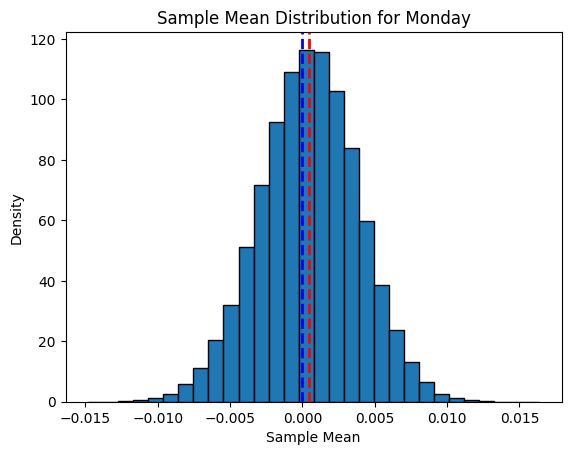

In [66]:

# Add vertical lines at the mean of sample means and at 0
plt.axvline(mean_of_sample_means, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_of_sample_means:.2f}')
plt.axvline(0, color='blue', linestyle='--', linewidth=2, label='0')

plt.hist(sample_means, bins=30, edgecolor='black', density=True)
plt.title('Sample Mean Distribution for Monday')
plt.xlabel('Sample Mean')
plt.ylabel('Density')
plt.show()

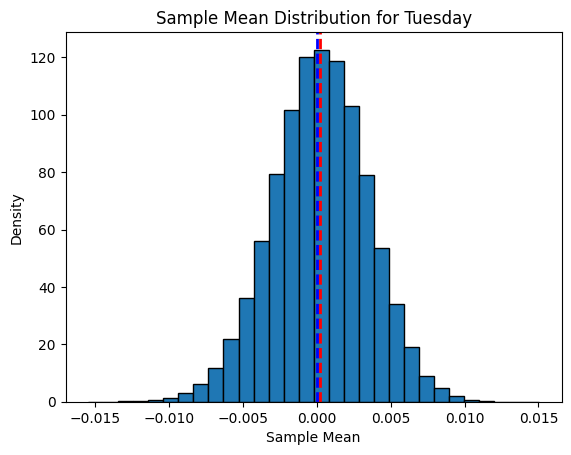

In [67]:
# Calculate sample mean distribution
sample_means = sample_mean_distribution(df[df['day'] == 1]['PnL'], sample_size, num_samples)
# Calculate the mean of the sample means
mean_of_sample_means = np.mean(sample_means)

# Add vertical lines at the mean of sample means and at 0
plt.axvline(mean_of_sample_means, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_of_sample_means:.2f}')
plt.axvline(0, color='blue', linestyle='--', linewidth=2, label='0')

plt.hist(sample_means, bins=30, edgecolor='black', density=True)
plt.title('Sample Mean Distribution for Tuesday')
plt.xlabel('Sample Mean')
plt.ylabel('Density')
plt.show()

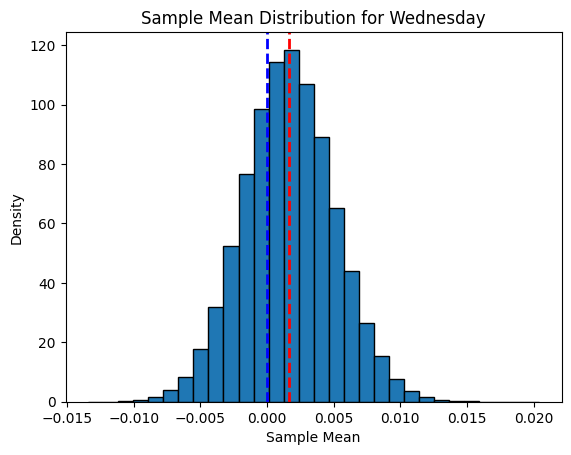

In [68]:
# Calculate sample mean distribution
sample_means = sample_mean_distribution(df[df['day'] == 2]['PnL'], sample_size, num_samples)
# Calculate the mean of the sample means
mean_of_sample_means = np.mean(sample_means)

# Add vertical lines at the mean of sample means and at 0
plt.axvline(mean_of_sample_means, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_of_sample_means:.2f}')
plt.axvline(0, color='blue', linestyle='--', linewidth=2, label='0')

plt.hist(sample_means, bins=30, edgecolor='black', density=True)
plt.title('Sample Mean Distribution for Wednesday')
plt.xlabel('Sample Mean')
plt.ylabel('Density')
plt.show()

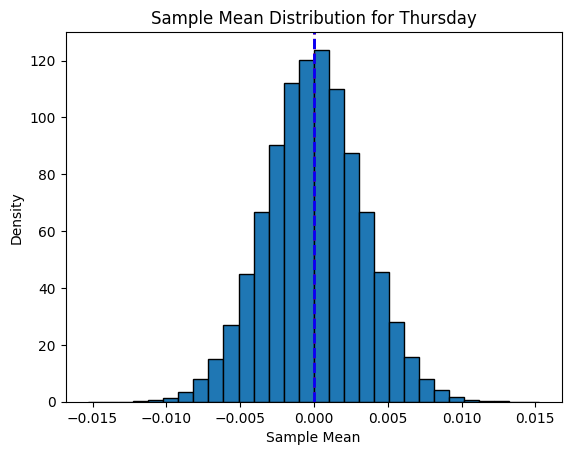

In [69]:
# Calculate sample mean distribution
sample_means = sample_mean_distribution(df[df['day'] == 3]['PnL'], sample_size, num_samples)
# Calculate the mean of the sample means
mean_of_sample_means = np.mean(sample_means)

# Add vertical lines at the mean of sample means and at 0
plt.axvline(mean_of_sample_means, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_of_sample_means:.2f}')
plt.axvline(0, color='blue', linestyle='--', linewidth=2, label='0')

plt.hist(sample_means, bins=30, edgecolor='black', density=True)
plt.title('Sample Mean Distribution for Thursday')
plt.xlabel('Sample Mean')
plt.ylabel('Density')
plt.show()

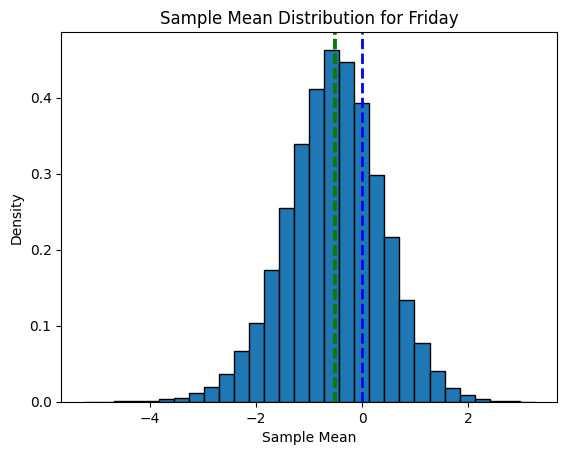

In [36]:
# Calculate sample mean distribution
sample_means = sample_mean_distribution(df[df['day'] == 0]['PnL_nonRTH'], sample_size, num_samples)
# Calculate the mean of the sample means
mean_of_sample_means = np.mean(sample_means)
# Calculate the mean and standard deviation of the sample means
mean_of_sample_means = np.mean(sample_means)
std_of_sample_means = np.std(sample_means)

# Calculate the 95% confidence interval for the mean
confidence_level = 0.95
z_score = stats.norm.ppf((1 + confidence_level) / 2)
margin_of_error = z_score * (std_of_sample_means / np.sqrt(num_samples))
confidence_interval = (mean_of_sample_means - margin_of_error, mean_of_sample_means + margin_of_error)

# Add vertical lines at the mean of sample means and at 0
plt.axvline(mean_of_sample_means, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_of_sample_means:.2f}')
plt.axvline(0, color='blue', linestyle='--', linewidth=2, label='0')

# Add confidence interval lines
plt.axvline(confidence_interval[0], color='green', linestyle='--', linewidth=2, label=f'Lower CI: {confidence_interval[0]:.2f}')
plt.axvline(confidence_interval[1], color='green', linestyle='--', linewidth=2, label=f'Upper CI: {confidence_interval[1]:.2f}')


plt.hist(sample_means, bins=30, edgecolor='black', density=True)
plt.title('Sample Mean Distribution for Friday')
plt.xlabel('Sample Mean')
plt.ylabel('Density')
plt.show()

Based on above analysis of META: 
- Best day is : Wednesday > Monday
- Worst Day: Friday, Thursday

In [99]:
# lets see if tommorow is positive or negative
tomorrow=0
(confidence_interval[0] - df[df['day'] == tomorrow]['PnL_nonRTH'][0:50].mean()), (confidence_interval[1] - df[df['day'] == tomorrow]['PnL_nonRTH'][0:20].mean())

(-0.19022794854287153, -0.22084631330704665)

In [95]:
confidence_interval

(-0.04709278884478352, -0.04303977705394302)

In [37]:
df['PnL_nonRTH_bin'] = np.where((df['PnL_nonRTH'])<0, -1, 1)
df['PnL_nonRTH_bin']

index
0       1
1      -1
2       1
3       1
4       1
       ..
3085    1
3086   -1
3087    1
3088    1
3089    1
Name: PnL_nonRTH_bin, Length: 3090, dtype: int64

In [38]:
# https://medium.com/@smitpate08/unleashing-the-power-of-categorical-relationships-with-pandas-in-python-82fbe3917338
# based on this doc, relationship testing
from scipy.stats import chi2_contingency

def check_relationship(data, alpha = 0.05):
    # Get all categorical columns in the DataFrame
    categorical_columns = data.columns
    results = []
    
    # Create a copy of the dataframe to avoid modifying the original
    data_copy = data.copy()
    
    # Remove rows containing missing values
    data_copy = data_copy.dropna(subset=categorical_columns)
    
    # Iterate over each pair of categorical columns
    for i in range(len(categorical_columns)):
        for j in range(i+1, len(categorical_columns)):
            col1 = categorical_columns[i]
            col2 = categorical_columns[j]
            
            # Create the contingency table for the two columns
            contingency_table = pd.crosstab(data_copy[col1], data_copy[col2])
            
            # Calculate the chi-squared test of independence
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            
            # Check if we reject the null hypothesis (i.e., if the columns are dependent)
            reject_null_hypothesis = p < alpha
            dependency = reject_null_hypothesis
            
            # Add the results to the list of results
            results.append({'column': col1, 'column_compared_with': col2, 'p-value': p, 'Null hypothesis rejected': reject_null_hypothesis, 'dependency': dependency})
    return pd.DataFrame(results).sort_values(by='p-value', ascending=False)

In [39]:
check_relationship(df[['day', 'PnL_nonRTH_bin']])

,column,column_compared_with,p-value,Null hypothesis rejected,dependency
0,day,PnL_nonRTH_bin,0.283637,False,False


In [61]:
df, dm = ts.get_weekly('META')

In [62]:
df['day'] = pd.to_datetime(df['index']).dt.weekofyear
df['PnL'] = np.where((df['4. close']-df['1. open'])<0, -1, 1)

/var/folders/ql/t_pwhj2x01x9pf367dwbv_5c0000gn/T/ipykernel_12478/3216668950.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['day'] = pd.to_datetime(df['index']).dt.weekofyear


In [63]:
check_relationship(df[['day', 'PnL']])

,column,column_compared_with,p-value,Null hypothesis rejected,dependency
0,day,PnL,0.766047,False,False


In [21]:
# Saver the data in parquet form for speed and compressed form of data
def updateAndSave(new_data, dm):
    filePath = './data'
    fileName = dm['2. Symbol'] + ".csv"
    full_path = os.path.join(filePath, fileName)
    
    # Check if the parquet file exists
    if os.path.exists(full_path):
        # Read the existing parquet file
        existing_data = pd.read_parquet(full_path)

        # Find rows that are not in the existing data
        updated_data = pd.concat([existing_data, new_data]).drop_duplicates(keep=False, ignore_index=True)
        
        # Combine existing data with unique new rows
        final_data = pd.concat([existing_data, updated_data], ignore_index=True)
        
    else:
        # If the file does not exist, use the new data as is
        updated_data = new_data

    # Save the updated DataFrame back to the parquet file
    updated_data.to_csv(full_path, index=False)

    